In [1]:
# @title Setup dan Instalasi
# Instal library yang diperlukan
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch_geometric

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 70.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 83.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 8.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 2.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 8.4 MB/s eta 0:00:000

In [2]:
# @title Impor Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize # Untuk efisiensi cosine similarity

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

import ast
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
import re

def string_to_numpy_array(s):
    """
    Konversi string representasi array NumPy (seperti yang dihasilkan repr(array))
    menjadi objek numpy.ndarray.
    """
    # Hapus karakter non-numeric dan whitespace yang tidak relevan
    # Ini mencakup spasi, tab, dan baris baru di dalam representasi array
    cleaned_str = re.sub(r'[^\d\s\.\-\+eE]+', ' ', s)
    # Pisahkan angka berdasarkan spasi
    numbers_str = cleaned_str.split()
    # Konversi ke float dan buat array numpy
    try:
        numbers = [float(n) for n in numbers_str]
        return np.array(numbers)
    except ValueError:
        # Jika ada nilai yang tidak bisa diubah menjadi float
        print(f"Warning: Tidak bisa mengonversi string '{s[:50]}...' menjadi array float. Melewati baris ini.")
        return np.array([]) # Atau return None, tergantung penanganan error yang diinginkan

# Sekarang gunakan fungsi ini di blok 1.1
# @title 1.1. Memuat Fitur dan Label dari File .xlsx
# Ganti 'path_to_your_file.xlsx' dengan path file Anda di Google Drive atau Kaggle
# Contoh: '/content/drive/MyDrive/data_berita.xlsx'
file_path = '/kaggle/input/news-with-vector-dataset/combined_with_vectors_cbow_sg.xlsx' # <--- Ganti dengan path file Anda

# Baca file .xlsx
df = pd.read_excel(file_path)

# Asumsikan kolom 'vector' berisi string representasi array numpy seperti output dari repr(numpy_array)
# Konversi string ke array numpy menggunakan fungsi di atas
df['vector_combined'] = df['vector_combined'].apply(string_to_numpy_array)

# Filter baris-baris yang mungkin gagal dikonversi (array kosong)
df = df[df['vector_combined'].apply(lambda x: len(x) > 0)]

# Pastikan semua vektor memiliki panjang yang sama
first_len = len(df['vector_combined'].iloc[0])
if not all(len(v) == first_len for v in df['vector_combined']):
    raise ValueError("Panjang vektor tidak konsisten di seluruh dataset.")

# Pisahkan fitur (A) dan label
X_raw = np.stack(df['vector_combined'].values) # Matriks Fitur (20000, dimensi_embedding)
y_raw = df['label'].values # Vektor Label

# Opsional: Ambil subset data jika terlalu besar untuk memori
# Misalnya, ambil 20000 data pertama
if len(X_raw) > 20000:
    X = X_raw[:20000]
    y = y_raw[:20000]
else:
    X = X_raw
    y = y_raw

print(f"Shape Matriks Fitur (A): {X.shape}")
print(f"Shape Vektor Label: {y.shape}")

Shape Matriks Fitur (A): (19013, 100)
Shape Vektor Label: (19013,)


In [4]:
# @title 1.2. Konstruksi Struktur Graf (berdasarkan Vektor Word2Vec) - Versi Efisien dengan Self-loops & Undirected
# Gunakan NearestNeighbors dari scikit-learn untuk efisiensi memori
# K adalah jumlah tetangga terdekat untuk setiap node (tanpa self-loop)
K = 10 # <--- Atur jumlah tetangga, bisa diubah untuk eksperimen

# Cosine similarity antar vektor bisa dihitung lebih cepat setelah normalisasi L2
X_normalized = normalize(X, norm='l2', axis=1)

# --- GUNAKAN DATA ASLI TANPA NORMALISASI L2 UNTUK EUCLIDEAN ---
X_for_euclidean = X # Gunakan data asli

# Buat model NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=K+1, metric='cosine', algorithm='brute') # brute force lebih aman untuk cosine
nbrs.fit(X_normalized)

# Temukan K+1 tetangga terdekat (termasuk dirinya sendiri)
distances, indices = nbrs.kneighbors(X_normalized)

# Buang tetangga pertama (dirinya sendiri) untuk mendapatkan K tetangga sejati
knn_indices = indices[:, 1:] # shape (n_samples, K)

# --- PEMBUATAN GRAF UNDIRECTED DAN PENAMBAHAN SELF-LOOPS ---
num_nodes = X.shape[0]

# 1. Bangun edge_index dari KNN (A ke B)
rows_knn = np.repeat(np.arange(num_nodes), K)
cols_knn = knn_indices.flatten()
edge_index_knn = np.stack([rows_knn, cols_knn], axis=0)

# 2. Bangun edge_index untuk versi terbalik (B ke A) untuk undirected
edge_index_reverse = np.stack([edge_index_knn[1], edge_index_knn[0]], axis=0)

# 3. Gabungkan edge KNN dan edge terbalik
edge_index_undirected = np.concatenate([edge_index_knn, edge_index_reverse], axis=1)

# 4. Tambahkan self-loops (node ke dirinya sendiri)
self_loop_edges = np.stack([np.arange(num_nodes), np.arange(num_nodes)], axis=0)

# 5. Gabungkan semua edge: KNN, Reverse, Self-loops
edge_index = np.concatenate([edge_index_undirected, self_loop_edges], axis=1)

# --- END PEMBUATAN GRAF UNDIRECTED DAN PENAMBAHAN SELF-LOOPS ---

# Konversi ke tensor PyTorch
X_tensor = torch.tensor(X, dtype=torch.float).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).to(device)

print(f"Edge index shape: {edge_index_tensor.shape}")
print(f"Jumlah edges sebelum menambahkan reverse dan self-loops: {K * num_nodes}")
print(f"Jumlah edges setelah menambahkan reverse dan self-loops: {edge_index_tensor.shape[1]}")

# Opsional: Gunakan torch_geometric.utils untuk membersihkan duplikat dan mengurutkan (lebih efisien untuk PyG)
from torch_geometric.utils import add_self_loops, sort_edge_index, remove_self_loops

# Jika kita hanya menambahkan KNN dan reverse, kita bisa gunakan fungsi PyG untuk menambah self-loops
# edge_index_no_self = torch.tensor(np.concatenate([edge_index_knn, edge_index_reverse], axis=1), dtype=torch.long).to(device)
# edge_index_tensor, _ = add_self_loops(edge_index_no_self, num_nodes=num_nodes)

# Tapi karena kita sudah menambahkannya secara manual, kita bisa menggunakan PyG untuk mengurutkan dan menghapus duplikat jika perlu
# edge_index_tensor, _ = sort_edge_index(edge_index_tensor)
# edge_index_tensor, _ = remove_self_loops(edge_index_tensor) # Hanya hapus duplikat self-loop
# print(f"Edge index shape after sorting/removing loops: {edge_index_tensor.shape}")

Edge index shape: torch.Size([2, 399273])
Jumlah edges sebelum menambahkan reverse dan self-loops: 190130
Jumlah edges setelah menambahkan reverse dan self-loops: 399273


In [5]:
# @title 1.3. & 1.4. Pelatihan dan Evaluasi Model GCN dengan 2 dan 3 Lapisan (Update: Evaluasi Berkala - Lengkap)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# [Bagian pembuatan mask dan data PyG tetap sama...]
# Bagi data menjadi train dan test (gunakan indeks numpy untuk train_test_split)
num_nodes = X_tensor.size(0) # Gunakan ukuran dari tensor yang sudah dibuat
node_indices = np.arange(num_nodes)
train_indices, test_indices = train_test_split(node_indices, test_size=0.2, stratify=y, random_state=42)

# Buat mask untuk train/test
train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_indices_tensor = torch.tensor(train_indices, dtype=torch.long).to(device)
test_indices_tensor = torch.tensor(test_indices, dtype=torch.long).to(device)
train_mask[train_indices_tensor] = True
test_mask[test_indices_tensor] = True

# Buat objek Data PyTorch Geometric
data = Data(x=X_tensor, edge_index=edge_index_tensor, y=y_tensor, train_mask=train_mask, test_mask=test_mask)

# Definisikan model GCN dengan jumlah lapisan dan dropout variabel
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        # Buat layer-layer GCN berdasarkan jumlah yang ditentukan
        self.convs = torch.nn.ModuleList()
        # Layer pertama
        self.convs.append(GCNConv(input_dim, hidden_dim))
        # Layer-layer tersembunyi
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        # Layer output
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_dim, output_dim))
        else:
            # Jika hanya 1 layer, langsung dari input ke output
            self.convs.append(GCNConv(input_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(len(self.convs)):
            x = self.convs[i](x, edge_index)
            if i != len(self.convs) - 1: # Aktivasi dan dropout hanya sebelum layer terakhir
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
        return F.log_softmax(x, dim=1)

# Fungsi pelatihan dan evaluasi
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask_name='test'):
    """
    Evaluates the model on the specified mask (train or test).
    Includes ROC-AUC calculation.
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # Gunakan mask yang sesuai
        mask = data.train_mask if mask_name == 'train' else data.test_mask
        y_pred = pred[mask].cpu().numpy()
        y_true = data.y[mask].cpu().numpy()
        unique_labels = np.unique(y_true)

        # Hitung metrik standar
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Hitung ROC-AUC
        # Konversi log_softmax ke softmax untuk mendapatkan probabilitas
        y_probs_tensor = torch.exp(out[mask]) # torch.exp mengembalikan softmax dari log_softmax
        y_probs = y_probs_tensor.cpu().numpy()

        # Karena kasusnya biner (hanya kelas 0 dan 1 terdeteksi), kita bisa gunakan probabilitas kelas 1
        if len(unique_labels) == 2:
            try:
                # Ambil probabilitas kelas positif (indeks 1)
                y_probs_positive_class = y_probs[:, 1]
                roc_auc = roc_auc_score(y_true, y_probs_positive_class)
            except ValueError as e:
                # print(f"Warning: ROC-AUC calculation failed for {mask_name}_mask: {e}") # Opsional: uncomment untuk debug
                roc_auc = 0.0
        else:
            # Jika hanya satu kelas dalam mask, ROC-AUC tidak terdefinisi secara baik
            # print(f"Only one class ({unique_labels[0]}) found in {mask_name}_mask, ROC-AUC is undefined.") # Opsional: uncomment untuk debug
            roc_auc = 0.0 # Atau np.nan

        return acc, precision, recall, f1, roc_auc

# Parameter umum
input_dim = X_tensor.shape[1] # Dimensi embedding dari fitur
hidden_dim = 128 # Dimensi tersembunyi
output_dim = len(np.unique(y)) # 2 untuk fakta/hoaks
lr = 0.005
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5
eval_every_n_epochs = 20 # <-- Tambahkan interval evaluasi

results = {}
history = {}

# --- Eksperimen: 2 Lapisan GCN ---
print("\n--- Eksperimen: 2 Lapisan GCN ---")
model_2layer = GCN(input_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=dropout_rate).to(device)
# Gunakan Adam sesuai preferensi Anda (meskipun kode sebelumnya menunjukkan SGD, komentar disini menyebut AdamW)
optimizer_2layer = torch.optim.AdamW(model_2layer.parameters(), lr=lr, weight_decay=weight_decay) # Mengikuti preferensi Adam
criterion = torch.nn.NLLLoss()

# Inisialisasi history untuk model 2 layer (termasuk akurasi, F1, dan AUC yang akan dihitung secara berkala)
history['2_layer'] = {
    'train_loss': [],
    'val_loss': [], # Tambahkan jika ingin menghitung loss validasi/test
    'train_acc': [],
    'test_acc': [],
    'train_f1': [], # Tambahkan untuk F1
    'test_f1': [],  # Tambahkan untuk F1
    'train_auc': [], # Tambahkan untuk AUC
    'test_auc': [],  # Tambahkan untuk AUC
    'epochs': []     # Epoch tempat evaluasi dilakukan
}

for epoch in range(epochs):
    loss = train(model_2layer, data, optimizer_2layer, criterion)
    history['2_layer']['train_loss'].append(loss)

    # Evaluasi akurasi, F1, dan AUC setiap eval_every_n_epochs epoch
    if (epoch + 1) % eval_every_n_epochs == 0:
        train_acc, _, _, train_f1, train_auc = evaluate(model_2layer, data, mask_name='train')
        test_acc, _, _, test_f1, test_auc = evaluate(model_2layer, data, mask_name='test')
        # Jika ingin menyimpan loss validasi/test juga
        # val_loss = evaluate_loss(model_2layer, data, mask_name='test', criterion=criterion)
        # history['2_layer']['val_loss'].append(val_loss)

        history['2_layer']['train_acc'].append(train_acc)
        history['2_layer']['test_acc'].append(test_acc)
        history['2_layer']['train_f1'].append(train_f1) # Simpan F1
        history['2_layer']['test_f1'].append(test_f1)   # Simpan F1
        history['2_layer']['train_auc'].append(train_auc) # Simpan AUC
        history['2_layer']['test_auc'].append(test_auc)   # Simpan AUC
        history['2_layer']['epochs'].append(epoch) # Simpan nomor epoch tempat evaluasi dilakukan

# Evaluasi akhir (termasuk ROC-AUC)
final_acc_2layer, final_precision_2layer, final_recall_2layer, final_f1_2layer, final_roc_auc_2layer = evaluate(model_2layer, data, mask_name='test')
results['2_layer'] = {
    'accuracy': final_acc_2layer,
    'precision': final_precision_2layer,
    'recall': final_recall_2layer,
    'f1': final_f1_2layer,
    'roc_auc': final_roc_auc_2layer
}
print(f'Final Test Accuracy (2-layer): {final_acc_2layer:.4f}')
print(f'Final Test Precision (2-layer): {final_precision_2layer:.4f}')
print(f'Final Test Recall (2-layer): {final_recall_2layer:.4f}')
print(f'Final Test F1-Score (2-layer): {final_f1_2layer:.4f}')
print(f'Final Test ROC-AUC (2-layer): {final_roc_auc_2layer:.4f}')

# --- Eksperimen: 3 Lapisan GCN ---
print("\n--- Eksperimen: 3 Lapisan GCN ---")
model_3layer = GCN(input_dim, hidden_dim, output_dim, num_layers=3, dropout_rate=dropout_rate).to(device)
optimizer_3layer = torch.optim.AdamW(model_3layer.parameters(), lr=lr, weight_decay=weight_decay) # Mengikuti preferensi Adam
criterion = torch.nn.NLLLoss()

# Inisialisasi history untuk model 3 layer (termasuk akurasi, F1, dan AUC yang akan dihitung secara berkala)
history['3_layer'] = {
    'train_loss': [],
    'val_loss': [], # Tambahkan jika ingin menghitung loss validasi/test
    'train_acc': [],
    'test_acc': [],
    'train_f1': [], # Tambahkan untuk F1
    'test_f1': [],  # Tambahkan untuk F1
    'train_auc': [], # Tambahkan untuk AUC
    'test_auc': [],  # Tambahkan untuk AUC
    'epochs': []     # Epoch tempat evaluasi dilakukan
}

for epoch in range(epochs):
    loss = train(model_3layer, data, optimizer_3layer, criterion)
    history['3_layer']['train_loss'].append(loss)

    # Evaluasi akurasi, F1, dan AUC setiap eval_every_n_epochs epoch
    if (epoch + 1) % eval_every_n_epochs == 0:
        train_acc, _, _, train_f1, train_auc = evaluate(model_3layer, data, mask_name='train')
        test_acc, _, _, test_f1, test_auc = evaluate(model_3layer, data, mask_name='test')
        # Jika ingin menyimpan loss validasi/test juga
        # val_loss = evaluate_loss(model_3layer, data, mask_name='test', criterion=criterion)
        # history['3_layer']['val_loss'].append(val_loss)

        history['3_layer']['train_acc'].append(train_acc)
        history['3_layer']['test_acc'].append(test_acc)
        history['3_layer']['train_f1'].append(train_f1) # Simpan F1
        history['3_layer']['test_f1'].append(test_f1)   # Simpan F1
        history['3_layer']['train_auc'].append(train_auc) # Simpan AUC
        history['3_layer']['test_auc'].append(test_auc)   # Simpan AUC
        history['3_layer']['epochs'].append(epoch) # Simpan nomor epoch tempat evaluasi dilakukan

# Evaluasi akhir (termasuk ROC-AUC)
final_acc_3layer, final_precision_3layer, final_recall_3layer, final_f1_3layer, final_roc_auc_3layer = evaluate(model_3layer, data, mask_name='test')
results['3_layer'] = {
    'accuracy': final_acc_3layer,
    'precision': final_precision_3layer,
    'recall': final_recall_3layer,
    'f1': final_f1_3layer,
    'roc_auc': final_roc_auc_3layer
}
print(f'Final Test Accuracy (3-layer): {final_acc_3layer:.4f}')
print(f'Final Test Precision (3-layer): {final_precision_3layer:.4f}')
print(f'Final Test Recall (3-layer): {final_recall_3layer:.4f}')
print(f'Final Test F1-Score (3-layer): {final_f1_3layer:.4f}')
print(f'Final Test ROC-AUC (3-layer): {final_roc_auc_3layer:.4f}')


--- Eksperimen: 2 Lapisan GCN ---
Final Test Accuracy (2-layer): 0.8564
Final Test Precision (2-layer): 0.8572
Final Test Recall (2-layer): 0.8564
Final Test F1-Score (2-layer): 0.8561
Final Test ROC-AUC (2-layer): 0.9333

--- Eksperimen: 3 Lapisan GCN ---
Final Test Accuracy (3-layer): 0.8525
Final Test Precision (3-layer): 0.8532
Final Test Recall (3-layer): 0.8525
Final Test F1-Score (3-layer): 0.8522
Final Test ROC-AUC (3-layer): 0.9321


In [6]:
# --- Perbandingan Performa ---
print("\n--- Perbandingan Performa ---")
# Tambahkan header ROC-AUC
print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
print("-" * 70) # Sesuaikan panjang garis dengan kolom tambahan
for model_name, metrics in results.items():
    # Tambahkan nilai ROC-AUC ke dalam format string
    print(f"{model_name:<10} {metrics['accuracy']:<10.4f} {metrics['precision']:<12.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics.get('roc_auc', 0.0):<10.4f}")



--- Perbandingan Performa ---
Model      Accuracy   Precision    Recall     F1-Score   ROC-AUC   
----------------------------------------------------------------------
2_layer    0.8564     0.8572       0.8564     0.8561     0.9333    
3_layer    0.8525     0.8532       0.8525     0.8522     0.9321    



--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---


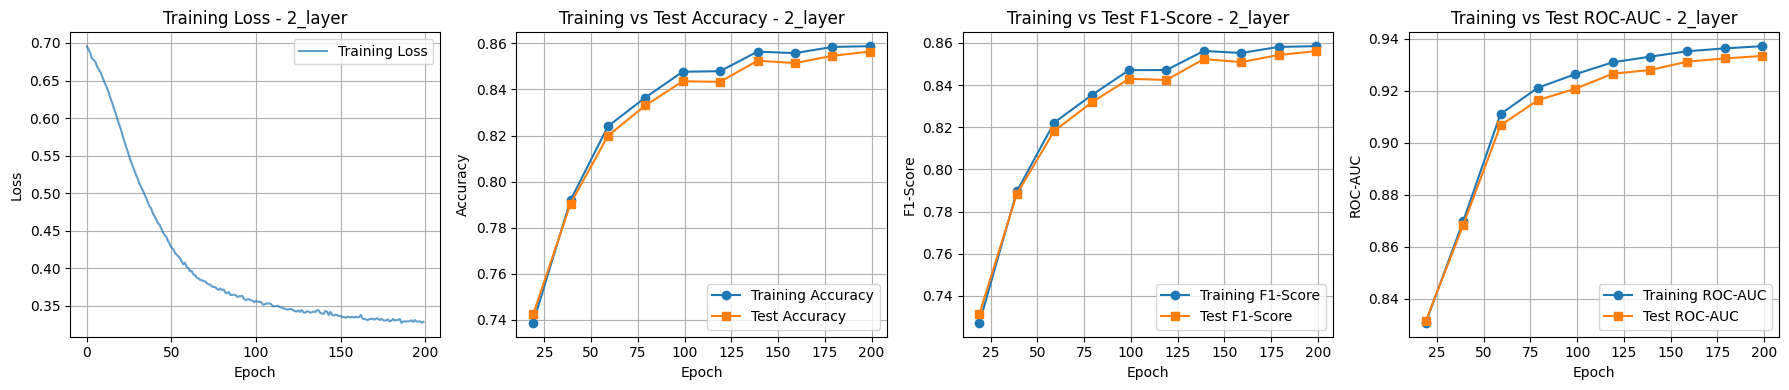


--- Analisis Underfitting dan Overfitting untuk 2_layer ---
Akurasi: Train=0.8588, Test=0.8564, Gap=0.0023
  - Akurasi pelatihan dan test baik & gap kecil, model tampaknya seimbang.
F1-Score: Train=0.8585, Test=0.8561, Gap=0.0024
  - F1-Score pelatihan dan test baik & gap kecil, model tampaknya seimbang.
ROC-AUC: Train=0.9371, Test=0.9333, Gap=0.0038
  - ROC-AUC pelatihan dan test baik & gap kecil, model tampaknya seimbang.

  -> Kesimpulan: Model 2_layer TAMPAKNYA seimbang (kinerja baik dan gap kecil).


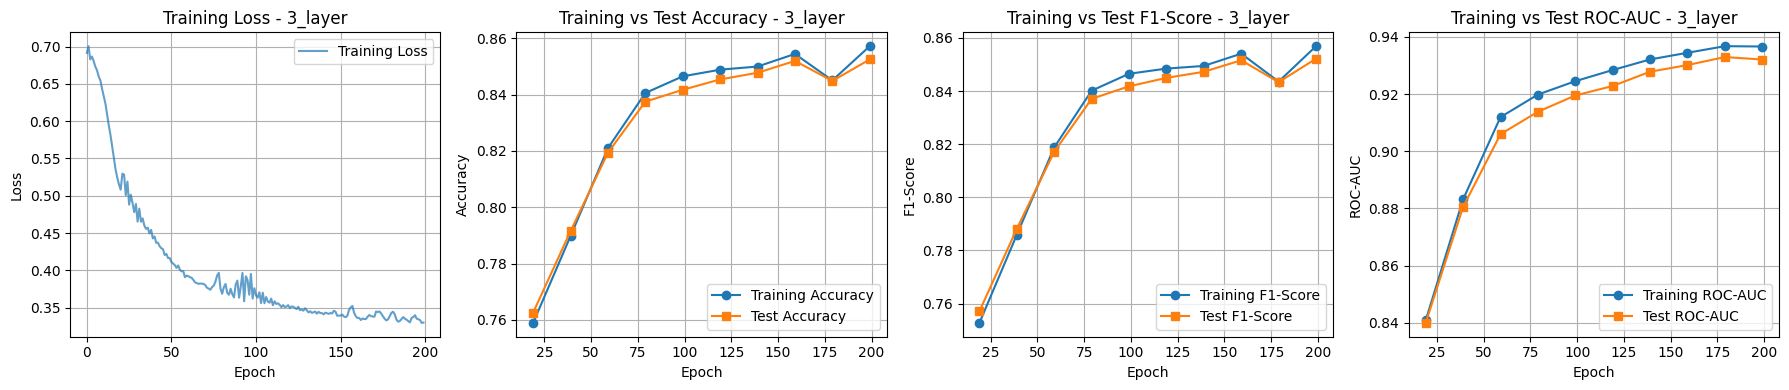


--- Analisis Underfitting dan Overfitting untuk 3_layer ---
Akurasi: Train=0.8572, Test=0.8525, Gap=0.0047
  - Akurasi pelatihan dan test baik & gap kecil, model tampaknya seimbang.
F1-Score: Train=0.8569, Test=0.8522, Gap=0.0047
  - F1-Score pelatihan dan test baik & gap kecil, model tampaknya seimbang.
ROC-AUC: Train=0.9366, Test=0.9321, Gap=0.0046
  - ROC-AUC pelatihan dan test baik & gap kecil, model tampaknya seimbang.

  -> Kesimpulan: Model 3_layer TAMPAKNYA seimbang (kinerja baik dan gap kecil).


In [7]:
# --- Analisis Overfitting dan Underfitting ---
print("\n--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---")

# Threshold untuk menentukan apakah kinerja dianggap 'rendah'
LOW_PERFORMANCE_THRESHOLD_ACC = 0.6  # Contoh nilai
LOW_PERFORMANCE_THRESHOLD_F1 = 0.6
LOW_PERFORMANCE_THRESHOLD_AUC = 0.6
# Threshold untuk menentukan apakah gap besar
LARGE_GAP_THRESHOLD = 0.05

for model_name in ['2_layer', '3_layer']:
    epochs = history[model_name]['epochs']
    train_accs = history[model_name]['train_acc']
    test_accs = history[model_name]['test_acc']
    train_f1s = history[model_name]['train_f1']
    test_f1s = history[model_name]['test_f1']
    train_aucs = history[model_name]['train_auc']
    test_aucs = history[model_name]['test_auc']
    train_losses = history[model_name]['train_loss']

    if not epochs:
        print(f"Peringatan: Tidak ada data evaluasi dicatat untuk {model_name}.")
        # Plot loss tetap bisa dilakukan
        if train_losses:
            plt.figure(figsize=(6, 4))
            plt.plot(list(range(len(train_losses))), train_losses, label=f'Training Loss - {model_name}')
            plt.title(f'Training Loss Over Epochs - {model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()
        continue

    # Plot metrik (sama seperti sebelumnya)
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 4, 1)
    all_epochs_for_loss = list(range(len(train_losses)))
    plt.plot(all_epochs_for_loss, train_losses, label='Training Loss', alpha=0.7)
    plt.title(f'Training Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
    plt.title(f'Training vs Test Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_f1s, label='Training F1-Score', marker='o')
    plt.plot(epochs, test_f1s, label='Test F1-Score', marker='s')
    plt.title(f'Training vs Test F1-Score - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_aucs, label='Training ROC-AUC', marker='o')
    plt.plot(epochs, test_aucs, label='Test ROC-AUC', marker='s')
    plt.title(f'Training vs Test ROC-AUC - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Analisis Underfitting ---
    # Ambil nilai akhir dari data evaluasi berkala
    final_train_acc = train_accs[-1] if train_accs else -1
    final_test_acc = test_accs[-1] if test_accs else -1
    final_train_f1 = train_f1s[-1] if train_f1s else -1
    final_test_f1 = test_f1s[-1] if test_f1s else -1
    final_train_auc = train_aucs[-1] if train_aucs else -1
    final_test_auc = test_aucs[-1] if test_aucs else -1

    print(f"\n--- Analisis Underfitting dan Overfitting untuk {model_name} ---")

    # Analisis berdasarkan akurasi
    if final_train_acc != -1 and final_test_acc != -1:
        gap_acc = final_train_acc - final_test_acc
        is_underfit_acc = final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC
        is_overfit_acc = gap_acc > LARGE_GAP_THRESHOLD

        print(f"Akurasi: Train={final_train_acc:.4f}, Test={final_test_acc:.4f}, Gap={gap_acc:.4f}")
        if is_underfit_acc:
            print("  - Akurasi pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_acc:
            print("  - Gap akurasi train-test besar, menunjukkan potensi overfitting.")
        else:
            print("  - Akurasi pelatihan dan test baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan F1-Score
    if final_train_f1 != -1 and final_test_f1 != -1:
        gap_f1 = final_train_f1 - final_test_f1
        is_underfit_f1 = final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1
        is_overfit_f1 = gap_f1 > LARGE_GAP_THRESHOLD

        print(f"F1-Score: Train={final_train_f1:.4f}, Test={final_test_f1:.4f}, Gap={gap_f1:.4f}")
        if is_underfit_f1:
            print("  - F1-Score pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_f1:
            print("  - Gap F1-Score train-test besar, menunjukkan potensi overfitting.")
        else:
            print("  - F1-Score pelatihan dan test baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan ROC-AUC
    if final_train_auc != -1 and final_test_auc != -1:
        gap_auc = final_train_auc - final_test_auc
        is_underfit_auc = final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC
        is_overfit_auc = gap_auc > LARGE_GAP_THRESHOLD

        print(f"ROC-AUC: Train={final_train_auc:.4f}, Test={final_test_auc:.4f}, Gap={gap_auc:.4f}")
        if is_underfit_auc:
            print("  - ROC-AUC pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_auc:
            print("  - Gap ROC-AUC train-test besar, menunjukkan potensi overfitting.")
        else:
            print("  - ROC-AUC pelatihan dan test baik & gap kecil, model tampaknya seimbang.")

    # Kesimpulan Gabungan Sederhana (contoh)
    underfit_indicators = [final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC if final_train_acc != -1 else False,
                           final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1 if final_train_f1 != -1 else False,
                           final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC if final_train_auc != -1 else False]
    overfit_indicators = [(final_train_acc - final_test_acc) > LARGE_GAP_THRESHOLD if final_train_acc != -1 and final_test_acc != -1 else False,
                          (final_train_f1 - final_test_f1) > LARGE_GAP_THRESHOLD if final_train_f1 != -1 and final_test_f1 != -1 else False,
                          (final_train_auc - final_test_auc) > LARGE_GAP_THRESHOLD if final_train_auc != -1 and final_test_auc != -1 else False]

    if any(underfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami UNDERFITTING (kinerja pelatihan rendah).")
    elif any(overfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami OVERFITTING (gap train-test besar).")
    else:
        print(f"\n  -> Kesimpulan: Model {model_name} TAMPAKNYA seimbang (kinerja baik dan gap kecil).")



--- Eksperimen: 2 Lapisan GCN ---
Final Test Accuracy (2-layer): 0.8552
Final Test Precision (2-layer): 0.8566
Final Test Recall (2-layer): 0.8552
Final Test F1-Score (2-layer): 0.8547
Final Test ROC-AUC (2-layer): 0.9385

--- Eksperimen: 3 Lapisan GCN ---
Final Test Accuracy (3-layer): 0.8559
Final Test Precision (3-layer): 0.8609
Final Test Recall (3-layer): 0.8559
Final Test F1-Score (3-layer): 0.8558
Final Test ROC-AUC (3-layer): 0.9367

--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---


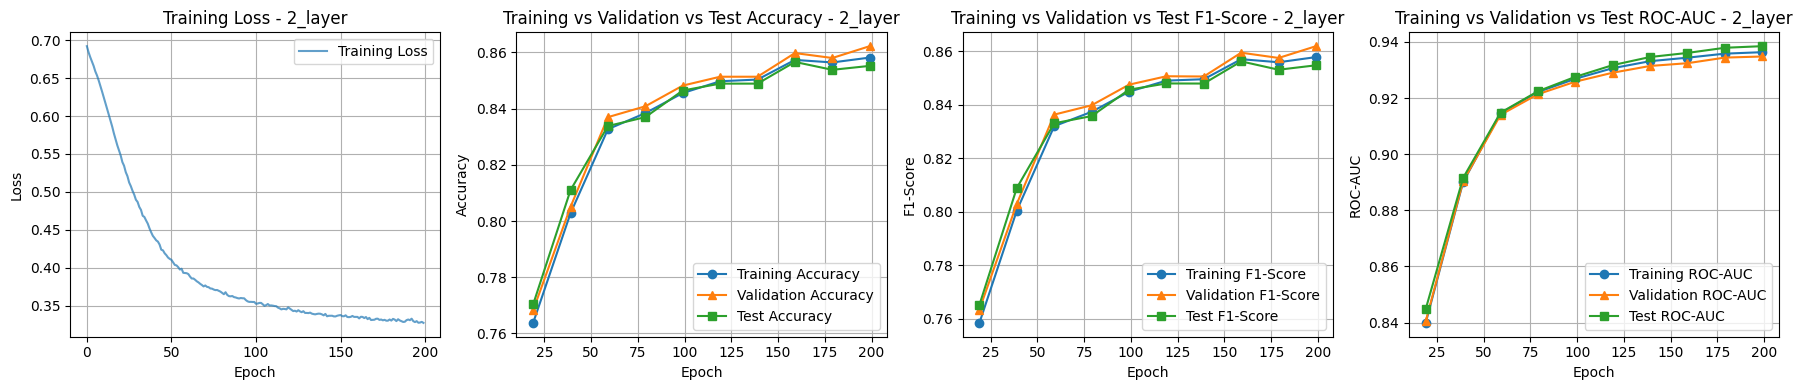


--- Analisis Underfitting dan Overfitting untuk 2_layer ---
Akurasi: Train=0.8581, Val=0.8622, Test=0.8552
  Gap Train-Val=-0.0041, Gap Val-Test=0.0070
  - Akurasi pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.
F1-Score: Train=0.8578, Val=0.8619, Test=0.8547
  Gap Train-Val=-0.0041, Gap Val-Test=0.0071
  - F1-Score pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.
ROC-AUC: Train=0.9364, Val=0.9348, Test=0.9385
  Gap Train-Val=0.0015, Gap Val-Test=-0.0037
  - ROC-AUC pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.

  -> Kesimpulan: Model 2_layer TAMPAKNYA seimbang (kinerja baik dan gap kecil).


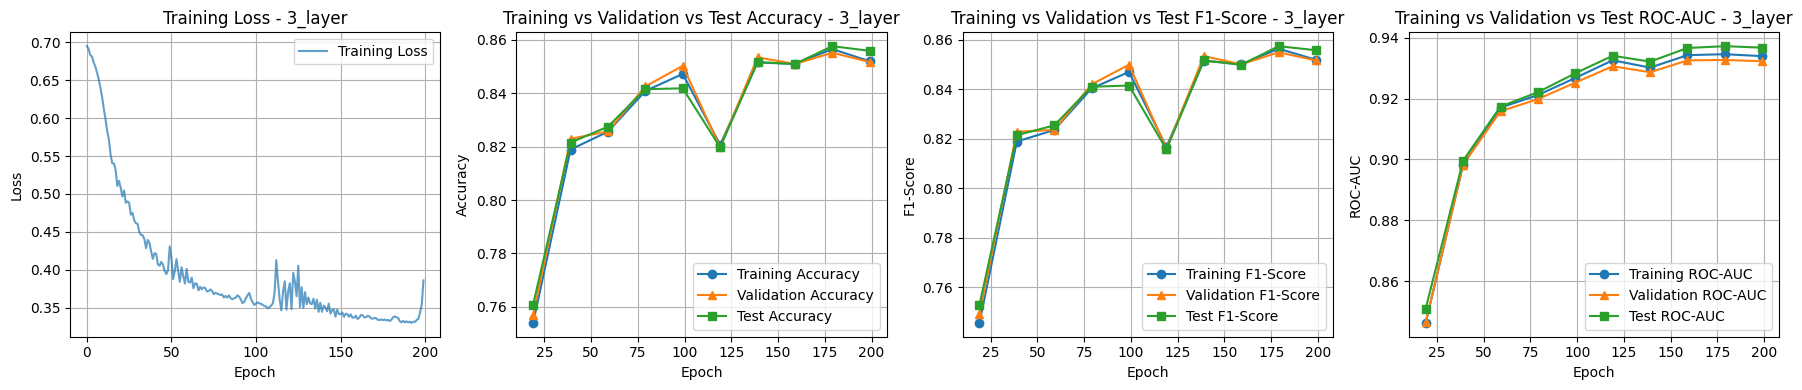


--- Analisis Underfitting dan Overfitting untuk 3_layer ---
Akurasi: Train=0.8520, Val=0.8517, Test=0.8559
  Gap Train-Val=0.0003, Gap Val-Test=-0.0042
  - Akurasi pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.
F1-Score: Train=0.8520, Val=0.8517, Test=0.8558
  Gap Train-Val=0.0003, Gap Val-Test=-0.0041
  - F1-Score pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.
ROC-AUC: Train=0.9340, Val=0.9323, Test=0.9367
  Gap Train-Val=0.0017, Gap Val-Test=-0.0045
  - ROC-AUC pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.

  -> Kesimpulan: Model 3_layer TAMPAKNYA seimbang (kinerja baik dan gap kecil).


In [8]:
# @title 1.3. & 1.4. Pelatihan dan Evaluasi Model GCN dengan 2 dan 3 Lapisan (Update: Evaluasi Berkala - Lengkap)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# [Bagian pembuatan mask dan data PyG disesuaikan untuk train/val/test...]
num_nodes = X_tensor.size(0) # Gunakan ukuran dari tensor yang sudah dibuat
node_indices = np.arange(num_nodes)

# Bagi data: 70% train, 15% validation, 15% test
# Langkah 1: Pisahkan 70% untuk train dan 30% untuk sisa (val + test)
train_indices, temp_indices, y_train, y_temp = train_test_split(
    node_indices, y, test_size=0.3, stratify=y, random_state=42
)
# Langkah 2: Bagi sisa 30% menjadi 15% validation dan 15% test
val_indices, test_indices, y_val, y_test = train_test_split(
    temp_indices, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Buat mask untuk train/validation/test
num_nodes = X_tensor.size(0) # Gunakan ukuran dari tensor yang sudah dibuat
train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)

# Konversi indeks numpy ke tensor dan isi mask
train_indices_tensor = torch.tensor(train_indices, dtype=torch.long).to(device)
val_indices_tensor = torch.tensor(val_indices, dtype=torch.long).to(device)
test_indices_tensor = torch.tensor(test_indices, dtype=torch.long).to(device)

train_mask[train_indices_tensor] = True
val_mask[val_indices_tensor] = True
test_mask[test_indices_tensor] = True

# Buat objek Data PyTorch Geometric
data = Data(x=X_tensor, edge_index=edge_index_tensor, y=y_tensor, 
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

# Definisikan model GCN dengan jumlah lapisan dan dropout variabel
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=0.5):
        super(GCN, self).__init__()
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        # Buat layer-layer GCN berdasarkan jumlah yang ditentukan
        self.convs = torch.nn.ModuleList()
        # Layer pertama
        self.convs.append(GCNConv(input_dim, hidden_dim))
        # Layer-layer tersembunyi
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        # Layer output
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_dim, output_dim))
        else:
            # Jika hanya 1 layer, langsung dari input ke output
            self.convs.append(GCNConv(input_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(len(self.convs)):
            x = self.convs[i](x, edge_index)
            if i != len(self.convs) - 1: # Aktivasi dan dropout hanya sebelum layer terakhir
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
        return F.log_softmax(x, dim=1)

# Fungsi pelatihan dan evaluasi
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask_name='test'):
    """
    Evaluates the model on the specified mask (train, val, or test).
    Includes ROC-AUC calculation.
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # Gunakan mask yang sesuai
        if mask_name == 'train':
            mask = data.train_mask
        elif mask_name == 'val':
            mask = data.val_mask
        else: # Default to test
            mask = data.test_mask
            
        y_pred = pred[mask].cpu().numpy()
        y_true = data.y[mask].cpu().numpy()
        unique_labels = np.unique(y_true)

        # Hitung metrik standar
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Hitung ROC-AUC
        # Konversi log_softmax ke softmax untuk mendapatkan probabilitas
        y_probs_tensor = torch.exp(out[mask]) # torch.exp mengembalikan softmax dari log_softmax
        y_probs = y_probs_tensor.cpu().numpy()

        # Karena kasusnya biner (hanya kelas 0 dan 1 terdeteksi), kita bisa gunakan probabilitas kelas 1
        if len(unique_labels) == 2:
            try:
                # Ambil probabilitas kelas positif (indeks 1)
                y_probs_positive_class = y_probs[:, 1]
                roc_auc = roc_auc_score(y_true, y_probs_positive_class)
            except ValueError as e:
                # print(f"Warning: ROC-AUC calculation failed for {mask_name}_mask: {e}") # Opsional: uncomment untuk debug
                roc_auc = 0.0
        else:
            # Jika hanya satu kelas dalam mask, ROC-AUC tidak terdefinisi secara baik
            # print(f"Only one class ({unique_labels[0]}) found in {mask_name}_mask, ROC-AUC is undefined.") # Opsional: uncomment untuk debug
            roc_auc = 0.0 # Atau np.nan

        return acc, precision, recall, f1, roc_auc

# Parameter umum
input_dim = X_tensor.shape[1] # Dimensi embedding dari fitur
hidden_dim = 128 # Dimensi tersembunyi
output_dim = len(np.unique(y)) # 2 untuk fakta/hoaks
lr = 0.005
weight_decay = 5e-4
epochs = 200
dropout_rate = 0.5
eval_every_n_epochs = 20 # <-- Tambahkan interval evaluasi

results = {}
history = {}

# --- Eksperimen: 2 Lapisan GCN ---
print("\n--- Eksperimen: 2 Lapisan GCN ---")
model_2layer = GCN(input_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=dropout_rate).to(device)
optimizer_2layer = torch.optim.AdamW(model_2layer.parameters(), lr=lr, weight_decay=weight_decay) # Mengikuti preferensi Adam
criterion = torch.nn.NLLLoss()

# Inisialisasi history untuk model 2 layer (termasuk train, val, test)
history['2_layer'] = {
    'train_loss': [],
    'val_loss': [], # Tambahkan jika ingin menghitung loss validasi
    'train_acc': [],
    'val_acc': [],
    'test_acc': [],
    'train_f1': [], # Tambahkan untuk F1
    'val_f1': [],
    'test_f1': [],  # Tambahkan untuk F1
    'train_auc': [], # Tambahkan untuk AUC
    'val_auc': [],
    'test_auc': [],  # Tambahkan untuk AUC
    'epochs': []     # Epoch tempat evaluasi dilakukan
}

for epoch in range(epochs):
    loss = train(model_2layer, data, optimizer_2layer, criterion)
    history['2_layer']['train_loss'].append(loss)

    # Evaluasi akurasi, F1, dan AUC setiap eval_every_n_epochs epoch
    if (epoch + 1) % eval_every_n_epochs == 0:
        # Evaluasi train
        train_acc, _, _, train_f1, train_auc = evaluate(model_2layer, data, mask_name='train')
        # Evaluasi validation
        val_acc, _, _, val_f1, val_auc = evaluate(model_2layer, data, mask_name='val')
        # Evaluasi test
        test_acc, _, _, test_f1, test_auc = evaluate(model_2layer, data, mask_name='test')

        history['2_layer']['train_acc'].append(train_acc)
        history['2_layer']['val_acc'].append(val_acc)
        history['2_layer']['test_acc'].append(test_acc)
        history['2_layer']['train_f1'].append(train_f1) # Simpan F1
        history['2_layer']['val_f1'].append(val_f1) # Simpan F1
        history['2_layer']['test_f1'].append(test_f1)   # Simpan F1
        history['2_layer']['train_auc'].append(train_auc) # Simpan AUC
        history['2_layer']['val_auc'].append(val_auc) # Simpan AUC
        history['2_layer']['test_auc'].append(test_auc)   # Simpan AUC
        history['2_layer']['epochs'].append(epoch) # Simpan nomor epoch tempat evaluasi dilakukan

# Evaluasi akhir (termasuk ROC-AUC) - hanya pada test set
final_acc_2layer, final_precision_2layer, final_recall_2layer, final_f1_2layer, final_roc_auc_2layer = evaluate(model_2layer, data, mask_name='test')
results['2_layer'] = {
    'accuracy': final_acc_2layer,
    'precision': final_precision_2layer,
    'recall': final_recall_2layer,
    'f1': final_f1_2layer,
    'roc_auc': final_roc_auc_2layer
}
print(f'Final Test Accuracy (2-layer): {final_acc_2layer:.4f}')
print(f'Final Test Precision (2-layer): {final_precision_2layer:.4f}')
print(f'Final Test Recall (2-layer): {final_recall_2layer:.4f}')
print(f'Final Test F1-Score (2-layer): {final_f1_2layer:.4f}')
print(f'Final Test ROC-AUC (2-layer): {final_roc_auc_2layer:.4f}')

# --- Eksperimen: 3 Lapisan GCN ---
print("\n--- Eksperimen: 3 Lapisan GCN ---")
model_3layer = GCN(input_dim, hidden_dim, output_dim, num_layers=3, dropout_rate=dropout_rate).to(device)
optimizer_3layer = torch.optim.AdamW(model_3layer.parameters(), lr=lr, weight_decay=weight_decay) # Mengikuti preferensi Adam
criterion = torch.nn.NLLLoss()

# Inisialisasi history untuk model 3 layer (termasuk train, val, test)
history['3_layer'] = {
    'train_loss': [],
    'val_loss': [], # Tambahkan jika ingin menghitung loss validasi
    'train_acc': [],
    'val_acc': [],
    'test_acc': [],
    'train_f1': [], # Tambahkan untuk F1
    'val_f1': [],
    'test_f1': [],  # Tambahkan untuk F1
    'train_auc': [], # Tambahkan untuk AUC
    'val_auc': [],
    'test_auc': [],  # Tambahkan untuk AUC
    'epochs': []     # Epoch tempat evaluasi dilakukan
}

for epoch in range(epochs):
    loss = train(model_3layer, data, optimizer_3layer, criterion)
    history['3_layer']['train_loss'].append(loss)

    # Evaluasi akurasi, F1, dan AUC setiap eval_every_n_epochs epoch
    if (epoch + 1) % eval_every_n_epochs == 0:
        # Evaluasi train
        train_acc, _, _, train_f1, train_auc = evaluate(model_3layer, data, mask_name='train')
        # Evaluasi validation
        val_acc, _, _, val_f1, val_auc = evaluate(model_3layer, data, mask_name='val')
        # Evaluasi test
        test_acc, _, _, test_f1, test_auc = evaluate(model_3layer, data, mask_name='test')

        history['3_layer']['train_acc'].append(train_acc)
        history['3_layer']['val_acc'].append(val_acc)
        history['3_layer']['test_acc'].append(test_acc)
        history['3_layer']['train_f1'].append(train_f1) # Simpan F1
        history['3_layer']['val_f1'].append(val_f1) # Simpan F1
        history['3_layer']['test_f1'].append(test_f1)   # Simpan F1
        history['3_layer']['train_auc'].append(train_auc) # Simpan AUC
        history['3_layer']['val_auc'].append(val_auc) # Simpan AUC
        history['3_layer']['test_auc'].append(test_auc)   # Simpan AUC
        history['3_layer']['epochs'].append(epoch) # Simpan nomor epoch tempat evaluasi dilakukan

# Evaluasi akhir (termasuk ROC-AUC) - hanya pada test set
final_acc_3layer, final_precision_3layer, final_recall_3layer, final_f1_3layer, final_roc_auc_3layer = evaluate(model_3layer, data, mask_name='test')
results['3_layer'] = {
    'accuracy': final_acc_3layer,
    'precision': final_precision_3layer,
    'recall': final_recall_3layer,
    'f1': final_f1_3layer,
    'roc_auc': final_roc_auc_3layer
}
print(f'Final Test Accuracy (3-layer): {final_acc_3layer:.4f}')
print(f'Final Test Precision (3-layer): {final_precision_3layer:.4f}')
print(f'Final Test Recall (3-layer): {final_recall_3layer:.4f}')
print(f'Final Test F1-Score (3-layer): {final_f1_3layer:.4f}')
print(f'Final Test ROC-AUC (3-layer): {final_roc_auc_3layer:.4f}')

# --- Analisis Overfitting dan Underfitting ---
print("\n--- Analisis Overfitting dan Underfitting (Lengkap: Akurasi, F1-Score, ROC-AUC) ---")

# Threshold untuk menentukan apakah kinerja dianggap 'rendah'
LOW_PERFORMANCE_THRESHOLD_ACC = 0.6  # Contoh nilai
LOW_PERFORMANCE_THRESHOLD_F1 = 0.6
LOW_PERFORMANCE_THRESHOLD_AUC = 0.6
# Threshold untuk menentukan apakah gap besar
LARGE_GAP_THRESHOLD = 0.05

for model_name in ['2_layer', '3_layer']:
    epochs = history[model_name]['epochs']
    train_accs = history[model_name]['train_acc']
    val_accs = history[model_name]['val_acc']
    test_accs = history[model_name]['test_acc']
    train_f1s = history[model_name]['train_f1']
    val_f1s = history[model_name]['val_f1']
    test_f1s = history[model_name]['test_f1']
    train_aucs = history[model_name]['train_auc']
    val_aucs = history[model_name]['val_auc']
    test_aucs = history[model_name]['test_auc']
    train_losses = history[model_name]['train_loss']

    if not epochs:
        print(f"Peringatan: Tidak ada data evaluasi dicatat untuk {model_name}.")
        # Plot loss tetap bisa dilakukan
        if train_losses:
            plt.figure(figsize=(6, 4))
            plt.plot(list(range(len(train_losses))), train_losses, label=f'Training Loss - {model_name}')
            plt.title(f'Training Loss Over Epochs - {model_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()
        continue

    # Plot metrik (sama seperti sebelumnya, tambahkan val line)
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 4, 1)
    all_epochs_for_loss = list(range(len(train_losses)))
    plt.plot(all_epochs_for_loss, train_losses, label='Training Loss', alpha=0.7)
    plt.title(f'Training Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Validation Accuracy', marker='^')
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
    plt.title(f'Training vs Validation vs Test Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_f1s, label='Training F1-Score', marker='o')
    plt.plot(epochs, val_f1s, label='Validation F1-Score', marker='^')
    plt.plot(epochs, test_f1s, label='Test F1-Score', marker='s')
    plt.title(f'Training vs Validation vs Test F1-Score - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_aucs, label='Training ROC-AUC', marker='o')
    plt.plot(epochs, val_aucs, label='Validation ROC-AUC', marker='^')
    plt.plot(epochs, test_aucs, label='Test ROC-AUC', marker='s')
    plt.title(f'Training vs Validation vs Test ROC-AUC - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Analisis Underfitting ---
    # Ambil nilai akhir dari data evaluasi berkala
    final_train_acc = train_accs[-1] if train_accs else -1
    final_val_acc = val_accs[-1] if val_accs else -1
    final_test_acc = test_accs[-1] if test_accs else -1
    final_train_f1 = train_f1s[-1] if train_f1s else -1
    final_val_f1 = val_f1s[-1] if val_f1s else -1
    final_test_f1 = test_f1s[-1] if test_f1s else -1
    final_train_auc = train_aucs[-1] if train_aucs else -1
    final_val_auc = val_aucs[-1] if val_aucs else -1
    final_test_auc = test_aucs[-1] if test_aucs else -1

    print(f"\n--- Analisis Underfitting dan Overfitting untuk {model_name} ---")

    # Analisis berdasarkan akurasi
    if all(v != -1 for v in [final_train_acc, final_val_acc, final_test_acc]):
        gap_acc_tv = final_train_acc - final_val_acc
        gap_acc_vt = final_val_acc - final_test_acc
        is_underfit_acc = final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC
        is_overfit_acc = gap_acc_tv > LARGE_GAP_THRESHOLD

        print(f"Akurasi: Train={final_train_acc:.4f}, Val={final_val_acc:.4f}, Test={final_test_acc:.4f}")
        print(f"  Gap Train-Val={gap_acc_tv:.4f}, Gap Val-Test={gap_acc_vt:.4f}")
        if is_underfit_acc:
            print("  - Akurasi pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_acc:
            print("  - Gap akurasi train-val besar, menunjukkan potensi overfitting.")
        else:
            print("  - Akurasi pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan F1-Score
    if all(v != -1 for v in [final_train_f1, final_val_f1, final_test_f1]):
        gap_f1_tv = final_train_f1 - final_val_f1
        gap_f1_vt = final_val_f1 - final_test_f1
        is_underfit_f1 = final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1
        is_overfit_f1 = gap_f1_tv > LARGE_GAP_THRESHOLD

        print(f"F1-Score: Train={final_train_f1:.4f}, Val={final_val_f1:.4f}, Test={final_test_f1:.4f}")
        print(f"  Gap Train-Val={gap_f1_tv:.4f}, Gap Val-Test={gap_f1_vt:.4f}")
        if is_underfit_f1:
            print("  - F1-Score pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_f1:
            print("  - Gap F1-Score train-val besar, menunjukkan potensi overfitting.")
        else:
            print("  - F1-Score pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.")

    # Analisis berdasarkan ROC-AUC
    if all(v != -1 for v in [final_train_auc, final_val_auc, final_test_auc]):
        gap_auc_tv = final_train_auc - final_val_auc
        gap_auc_vt = final_val_auc - final_test_auc
        is_underfit_auc = final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC
        is_overfit_auc = gap_auc_tv > LARGE_GAP_THRESHOLD

        print(f"ROC-AUC: Train={final_train_auc:.4f}, Val={final_val_auc:.4f}, Test={final_test_auc:.4f}")
        print(f"  Gap Train-Val={gap_auc_tv:.4f}, Gap Val-Test={gap_auc_vt:.4f}")
        if is_underfit_auc:
            print("  - ROC-AUC pelatihan rendah, menunjukkan potensi underfitting.")
        elif is_overfit_auc:
            print("  - Gap ROC-AUC train-val besar, menunjukkan potensi overfitting.")
        else:
            print("  - ROC-AUC pelatihan dan validasi baik & gap kecil, model tampaknya seimbang.")

    # Kesimpulan Gabungan Sederhana (contoh)
    # Fokus pada perbandingan train vs val untuk deteksi over/underfit
    underfit_indicators = [
        final_train_acc < LOW_PERFORMANCE_THRESHOLD_ACC if final_train_acc != -1 else False,
        final_train_f1 < LOW_PERFORMANCE_THRESHOLD_F1 if final_train_f1 != -1 else False,
        final_train_auc < LOW_PERFORMANCE_THRESHOLD_AUC if final_train_auc != -1 else False
    ]
    overfit_indicators = [
        (final_train_acc - final_val_acc) > LARGE_GAP_THRESHOLD if final_train_acc != -1 and final_val_acc != -1 else False,
        (final_train_f1 - final_val_f1) > LARGE_GAP_THRESHOLD if final_train_f1 != -1 and final_val_f1 != -1 else False,
        (final_train_auc - final_val_auc) > LARGE_GAP_THRESHOLD if final_train_auc != -1 and final_val_auc != -1 else False
    ]

    if any(underfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami UNDERFITTING (kinerja pelatihan rendah).")
    elif any(overfit_indicators):
        print(f"\n  -> Kesimpulan: Model {model_name} MUNGKIN mengalami OVERFITTING (gap train-val besar).")
    else:
        print(f"\n  -> Kesimpulan: Model {model_name} TAMPAKNYA seimbang (kinerja baik dan gap kecil).")
